#### Hier werden Simulationen mit DGP von Belloni et al. und mit verschiedenen R2_d und R2_y Parametern durchgelaufen.

In [ ]:
# Notwendige Bibliotheken und Funktionen importieren
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys, os
# hier den Pfad zu der Funktion pscore_discard aus functions.py einfügen
sys.path.append(os.path.abspath("."))
from DGP import propensity_eq, potential_outcome_eq, make_irm_data
from doubleml import DoubleMLIRM, DoubleMLData
from doubleml.utils.resampling import DoubleMLResampling
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegressionCV, LassoCV
from joblib import Parallel, delayed
from functions import pscore_discard
import warnings
# Alle Warnungen unterdrücken
warnings.filterwarnings("ignore")

### Daten generieren

In [2]:
# Seed für Reproduzierbarkeit setzen
np.random.seed(1234)
# Parameter für DGP festlegen
R2_d_values = [0.35, 0.5, 0.65, 0.8]
R2_y_values = [0.35, 0.5, 0.65, 0.8]
dim_x = 2
true_theta = 0 
n_obs = 1000

# Daten für verschiedene Kombinationen von R2_d und R2_y generieren und speichern
data_storage = {}
for R2_y in R2_y_values:
    data_storage_r2d = {}
    for R2_d in R2_d_values:
        data_storage_r2d[R2_d] = make_irm_data(n_obs=n_obs, R2_d=R2_d, R2_y=R2_y, dim_x=dim_x, theta=true_theta)
    data_storage[R2_y] = data_storage_r2d

### Verteilung der wahren Propensity Scores in der Gesamtpopulation darstellen

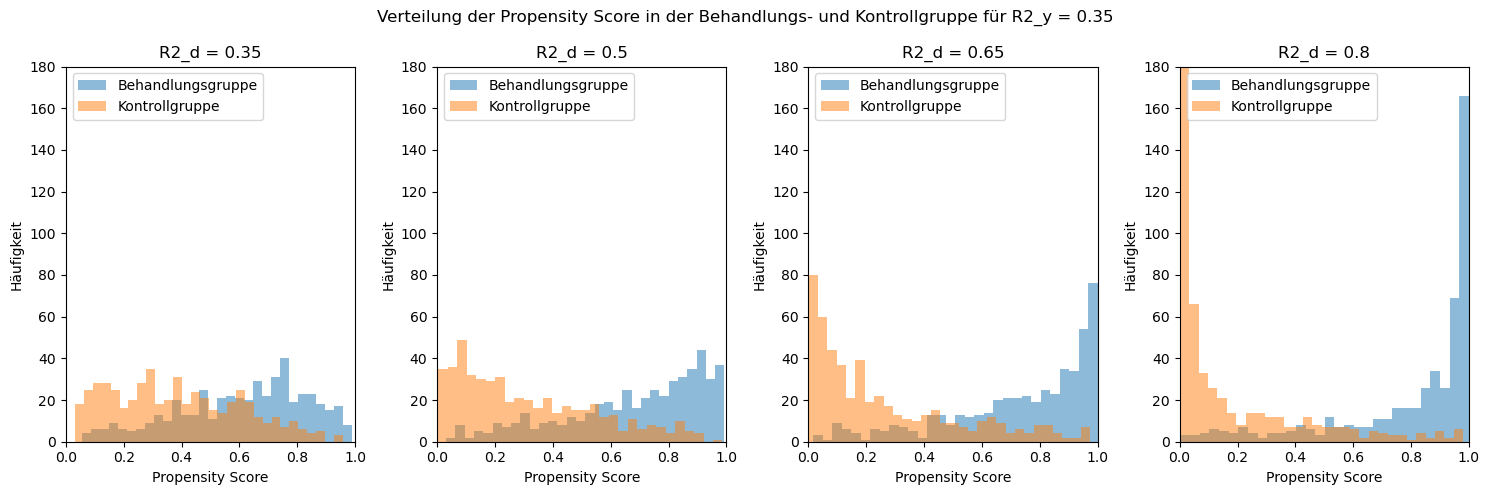

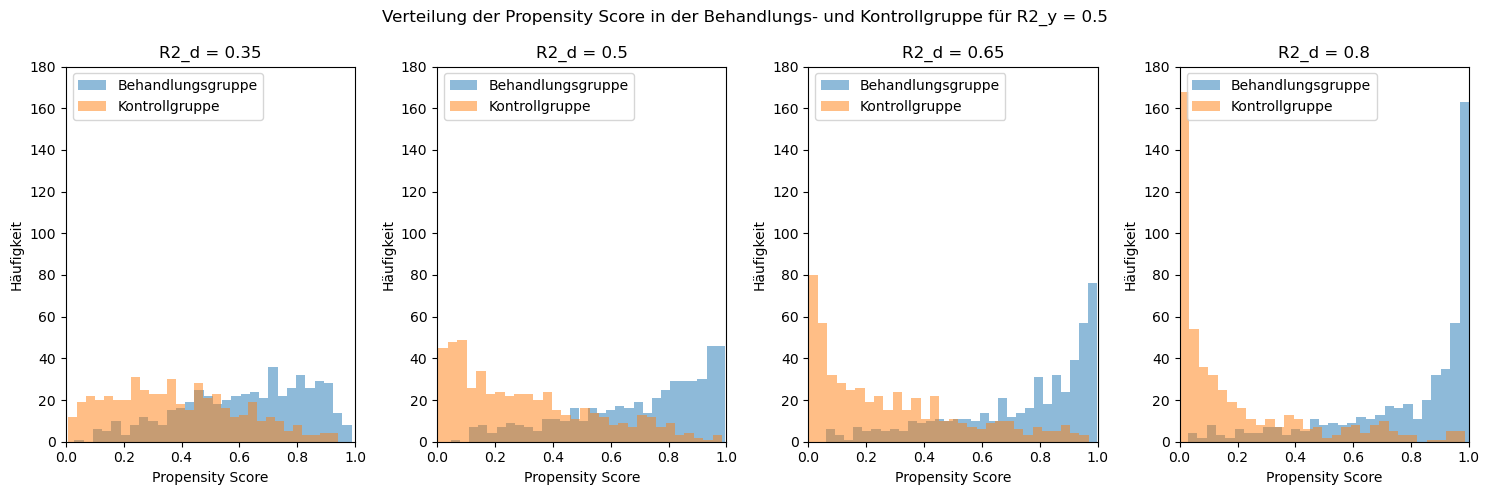

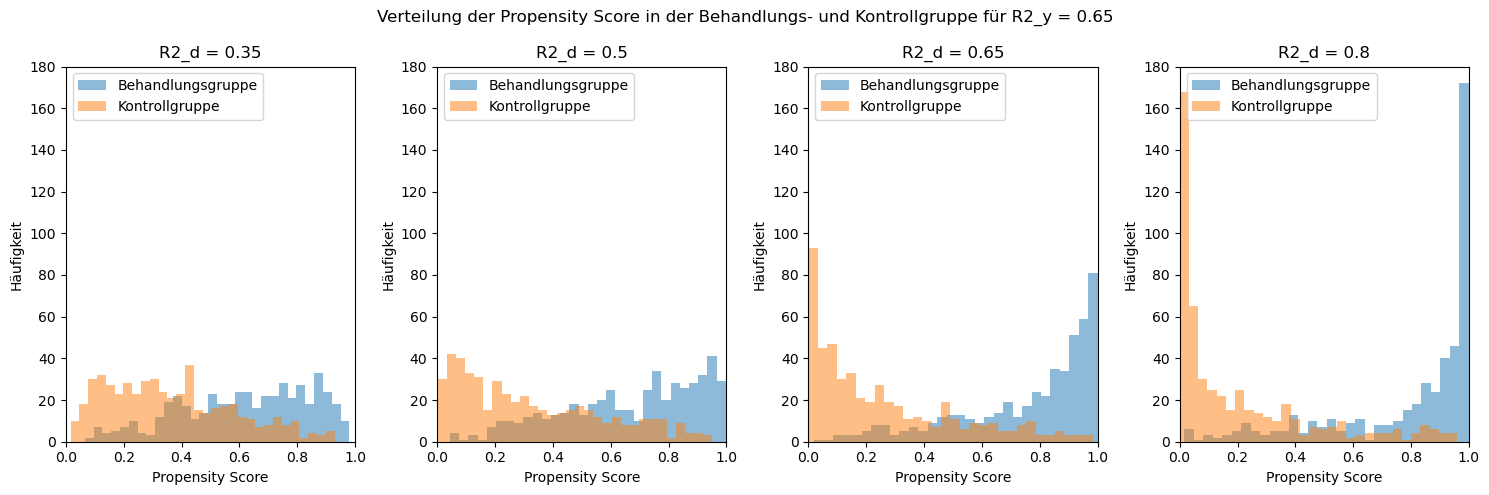

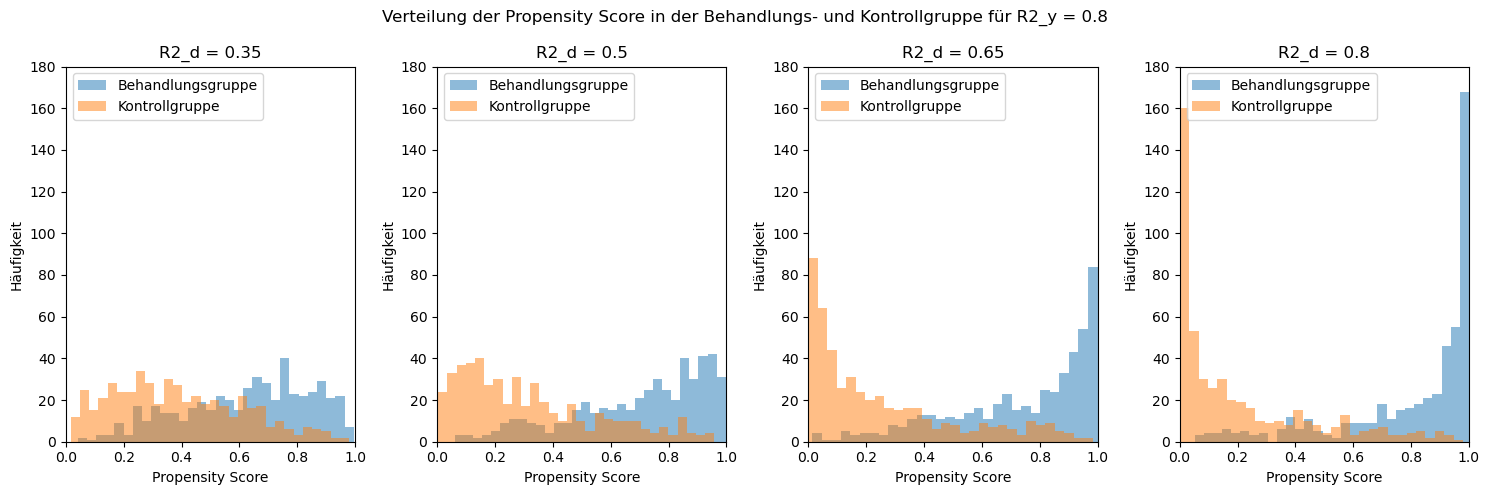

In [3]:
for R2_y in R2_y_values:
    datar2y = data_storage[R2_y]
    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    axes = ax.flatten()
    plot_index = 0

    for R2_d in R2_d_values:
        data = datar2y[R2_d]['df_orcl']
        ax = axes[plot_index]
        ax.hist(data.loc[data['D'] == 1, 'ps'], bins=30, alpha=0.5, label='Behandlungsgruppe')
        ax.hist(data.loc[data['D'] == 0, 'ps'], bins=30, alpha=0.5, label='Kontrollgruppe')
        ax.set_title(f'R2_d = {R2_d}')
        ax.set_xlabel('Propensity Score')
        ax.set_ylabel('Häufigkeit')
        ax.set_ylim(0, 180)
        ax.set_xlim(0, 1)
        ax.legend(loc='upper left')   
        plot_index += 1
    plt.suptitle(f'Verteilung der Propensity Score in der Behandlungs- und Kontrollgruppe für R2_y = {R2_y}')
    plt.tight_layout()
    plt.show()

### Schätzung des ATE und ATTE mit DoubleML und der Truncation Strategie

In [ ]:
# Seed für Reproduzierbarkeit setzen
np.random.seed(1234)
# Funktion für die Schätzung der Effekte erstellen
def run_trunc(i, R2_d, R2_y, true_theta, ml_g, ml_m, scr):
    results_trunc = []
    np.random.seed(i)
    df_data_dict = make_irm_data(n_obs=n_obs, R2_d=R2_d, R2_y=R2_y, dim_x=dim_x, theta=true_theta)
    data = DoubleMLData(df_data_dict['df'], 'Y', 'D', ['x_0', 'x_1'])
    df_orcl = df_data_dict['df_orcl']
    for trim_value in [0.001, 0.01, 0.05, 0.1]:
        dml_obj = DoubleMLIRM(data, ml_g, ml_m, trimming_threshold=trim_value, score=scr)
        dml_obj.fit()
        dml_summary = dml_obj.summary
        dml_summary['trim_value'] = trim_value
        dml_summary['R2_d'] = R2_d
        dml_summary['R2_y'] = R2_y
        dml_summary['share_trimmed_top'] = (((dml_obj.predictions['ml_m'].flatten() == (1-trim_value)).sum()) / n_obs)*100
        dml_summary['share_trimmed_bottom'] = (((dml_obj.predictions['ml_m'].flatten() == trim_value).sum())/ n_obs)*100
        dml_summary['share_treated'] = (((df_data_dict['df']['D'] == 1).sum())/ n_obs)*100 

        if scr == 'ATTE':
            dml_summary['oracle'] = np.mean(df_orcl.loc[df_orcl['D'] == 1, 'Y_1'] - df_orcl.loc[df_orcl['D'] == 1, 'Y_0'])
        else:
            dml_summary['oracle'] = np.mean(df_orcl.Y_1 - df_orcl.Y_0)

        results_trunc.append(dml_summary)
    return results_trunc

# Parameter für die Simulationen festlegen
R2_d_values = [0.35, 0.5, 0.65, 0.8]
R2_y_values = [0.35, 0.5, 0.65, 0.8]
dim_x = 2
true_theta = 0 
n_obs = 1000
ml_g, ml_m = LassoCV(), LogisticRegressionCV()
score_list = ["ATTE", "ATE"] 

# Simulation parallel durchlaufen
sim_trunc_atte = {}
sim_trunc_ate = {}
for R2_y in R2_y_values:
    res_trunc_atte = {}
    res_trunc_ate = {}
    for R2_d in R2_d_values:
        for scr in score_list:
            results_trunc = Parallel(n_jobs=-1)(delayed(run_trunc)(i, R2_d, R2_y, true_theta, ml_g, ml_m, scr) for i in range(1000))
            if scr == "ATTE":
                res_trunc_atte[R2_d] = results_trunc
            else:
                res_trunc_ate[R2_d] = results_trunc
    sim_trunc_atte[R2_y] = res_trunc_atte
    sim_trunc_ate[R2_y] = res_trunc_ate

In [ ]:
# normalisierte Verzerrung und Anteil von Oracle Werten im Konfidenzintervall berechnen
sim_trunc_atte2 = {}
sim_trunc_ate2 = {}
for R2_y in R2_y_values:
    for res in [sim_trunc_atte, sim_trunc_ate]:
        res_r2y = res[R2_y]
        result_atte = {}
        result_ate = {}
        for R2_d in R2_d_values:
            dfs = res_r2y[R2_d]
            # Kombinieren die DataFrames innerhalb jeder inneren Liste und dann zu einem einzigen DataFrame speichern
            combined_dfs = [pd.concat(inner_list, ignore_index=True) for inner_list in dfs]
            result_df = pd.concat(combined_dfs, ignore_index=True)
            if res is sim_trunc_atte: #ATTE
                result_df['norm_bias'] = (result_df['coef']-result_df['oracle'])/result_df['std err']
                result_df['in_ci'] = np.where(((result_df['oracle'] >= result_df['2.5 %']) & (result_df['oracle'] <= result_df['97.5 %'])), 1, 0)
                result_atte[R2_d] = result_df
            else: #ATE
                result_df['norm_bias'] = (result_df['coef']-true_theta)/result_df['std err']
                result_df['in_ci'] = np.where(((result_df['oracle'] >= result_df['2.5 %']) & (result_df['oracle'] <= result_df['97.5 %'])), 1, 0)
                result_ate[R2_d] = result_df

        if res is sim_trunc_atte: #ATTE
            sim_trunc_atte2[R2_y] = result_atte
        else: #ATE
            sim_trunc_ate2[R2_y] = result_ate

In [ ]:
# Mittlere normalisierte Verzerrung, Varianz, MSE und Coverage berechnen
sim_trunc_atte3 = {}
sim_trunc_ate3 = {}
for R2_y in R2_y_values:
    for res in [sim_trunc_atte2, sim_trunc_ate2]:
        res_r2y = res[R2_y]
        result_atte = {}
        result_ate = {}
        for R2_d in R2_d_values:
            df = res_r2y[R2_d]
            for col in df.trim_value.unique():
                df.loc[df['trim_value'] == col, 'mean_bias'] = df.loc[df['trim_value'] == col, 'norm_bias'].mean()
                df.loc[df['trim_value'] == col, 'var'] = df.loc[df['trim_value'] == col, 'norm_bias'].var()
                df.loc[df['trim_value'] == col, 'MSE'] = (df.loc[df['trim_value'] == col, 'norm_bias'].pow(2)).mean()
                df.loc[df['trim_value'] == col, 'coverage'] = df.loc[df['trim_value'] == col, 'in_ci'].mean()
            if res is sim_trunc_atte2: #ATTE
                result_atte[R2_d] = df
            else: #ATE
                result_ate[R2_d] = df

        if res is sim_trunc_atte2:
            sim_trunc_atte3[R2_y] = result_atte
        else:
            sim_trunc_ate3[R2_y] = result_ate        

In [7]:
# Ergebnisse als csv Datei speichern
trunc_atte_final = []
trunc_ate_final = []
for res in [sim_trunc_atte3, sim_trunc_ate3]:
    for R2_y in R2_y_values:
        res_r2y = res[R2_y]
        for R2_d in R2_d_values:        
            result_df = res_r2y[R2_d]
            if res is sim_trunc_atte3:
                trunc_atte_final.append(result_df)
            else:
                trunc_ate_final.append(result_df)

df_trunc_atte = pd.concat(trunc_atte_final, ignore_index=True)
df_trunc_ate = pd.concat(trunc_ate_final, ignore_index=True)

df_trunc_atte.to_csv('trunc_atte_r2.csv', index=False)
df_trunc_ate.to_csv('trunc_ate_r2.csv', index=False)

### Schätzung des ATE und ATTE mit DoubleML und mit Discarding Strategie

In [8]:
# Seed für Reproduzierbarkeit setzen
np.random.seed(1234)
# Funktion für die Schätzung der Effekte erstellen
def run_discard(i, R2_d, R2_y, true_theta, ml_g, ml_m, scr):
    results_discard = []
    np.random.seed(i)
    df_data_dict = make_irm_data(n_obs=n_obs, R2_d=R2_d, R2_y=R2_y, dim_x=dim_x, theta=true_theta)
    data = df_data_dict['df'] 
    
    # Cross-Fitting
    resampling_obj = DoubleMLResampling(n_folds = 5, n_rep = 1, n_obs=n_obs, stratify=data['D'])
    smpls = resampling_obj.split_samples()

    # Propensity Score schätzen
    pscore_est = cross_val_predict(ml_m, data.drop(columns=["Y", "D"]), data['D'], method='predict_proba', cv=resampling_obj.resampling)[:,1]

    for trim_value in [0.001, 0.01, 0.05, 0.1]:
        smpls_new, data_trimmed, pscore_trimmed = pscore_discard(data, pscore_est, smpls, trim_value)

        # DMLData Objekt erstellen
        dml_data= DoubleMLData.from_arrays(x=data_trimmed.drop(columns=["Y", "D"]), y=data_trimmed['Y'], d=data_trimmed['D'])
        dml_obj = DoubleMLIRM(dml_data, ml_g, ml_m, trimming_threshold=1e-12, draw_sample_splitting=False, score=scr)
        dml_obj.set_sample_splitting(smpls_new)
        dml_obj.fit(external_predictions = {"d":{"ml_m":pscore_trimmed}})
        dml_summary = dml_obj.summary
        dml_summary['trim_value'] = trim_value
        dml_summary['R2_d'] = R2_d
        dml_summary['R2_y'] = R2_y
        dml_summary['share_trimmed_top'] = ((np.where(pscore_est > (1-trim_value), 1, 0).sum())/ pscore_est.shape[0])*100
        dml_summary['share_trimmed_bottom'] = ((np.where(pscore_est < trim_value, 1, 0).sum()) / pscore_est.shape[0])*100
        dml_summary['share_treated_pop'] = (((data['D'] == 1).sum()) / n_obs)*100
        dml_summary['share_treated_smpl'] = (((data_trimmed['D'] == 1).sum()) / data_trimmed.shape[0])*100

        # Subpopulation nach dem Discarding
        data_orcl = df_data_dict['df_orcl'].iloc[data_trimmed.index]

        if scr == 'ATTE':
            dml_summary['oracle'] = np.mean(data_orcl.loc[data_orcl['D'] == 1, 'Y_1'] - data_orcl.loc[data_orcl['D'] == 1, 'Y_0'])
        else:
            dml_summary['oracle'] = np.mean(data_orcl.Y_1 - data_orcl.Y_0) 

        results_discard.append(dml_summary)
    return results_discard

# Parameter für die Simulation festlegen
R2_d_values = [0.35, 0.5, 0.65, 0.8]
R2_y_values = [0.35, 0.5, 0.65, 0.8]
dim_x = 2
true_theta = 0 
n_obs = 1000
ml_g, ml_m = LassoCV(), LogisticRegressionCV()
score_list = ["ATTE", "ATE"] 

# Simulation parallel durchlaufen
sim_discard_atte = {}
sim_discard_ate = {}

for R2_y in R2_y_values:
    res_discard_atte = {}
    res_discard_ate = {}
    for R2_d in R2_d_values:
        for scr in score_list:
            results_discard = Parallel(n_jobs=-1)(delayed(run_discard)(i, R2_d, R2_y, true_theta, ml_g, ml_m, scr) for i in range(1000))
            if scr == "ATTE":
                res_discard_atte[R2_d] = results_discard
            else:
                res_discard_ate[R2_d] = results_discard
    sim_discard_atte[R2_y] = res_discard_atte
    sim_discard_ate[R2_y] = res_discard_ate

In [9]:
# normalisierte Verzerrung, Anteil der Oracle Werte in KI berechnen
sim_discard_atte2 = {}
sim_discard_ate2 = {}
for R2_y in R2_y_values:
    for res in [sim_discard_atte, sim_discard_ate]:
        res_r2y = res[R2_y]
        result_atte = {}
        result_ate = {}
        for R2_d in R2_d_values:
            dfs = res_r2y[R2_d]
            # Kombinieren die DataFrames innerhalb jeder inneren Liste und dann zu einem einzigen DataFrame speichern
            combined_dfs = [pd.concat(inner_list, ignore_index=True) for inner_list in dfs]
            result_df = pd.concat(combined_dfs, ignore_index=True)            
            if res is sim_discard_atte: #ATTE
                result_df['norm_bias'] = (result_df['coef']-result_df['oracle'])/result_df['std err']
                result_df['in_ci'] = np.where(((result_df['oracle'] >= result_df['2.5 %']) & (result_df['oracle'] <= result_df['97.5 %'])), 1, 0)
                result_atte[R2_d] = result_df
            else: #ATE
                result_df['norm_bias'] = (result_df['coef']-true_theta)/result_df['std err']
                result_df['in_ci'] = np.where(((result_df['oracle'] >= result_df['2.5 %']) & (result_df['oracle'] <= result_df['97.5 %'])), 1, 0)
                result_ate[R2_d] = result_df
        if res is sim_discard_atte: #ATTE
            sim_discard_atte2[R2_y] = result_atte
        else: #ATE
            sim_discard_ate2[R2_y] = result_ate

In [ ]:
# Mittlere normalisierte Verzerrung, Varianz, MSE und Coverage berechnen
sim_discard_atte3 = {}
sim_discard_ate3 = {}
for R2_y in R2_y_values:
    for res in [sim_discard_atte2, sim_discard_ate2]:
        res_r2y = res[R2_y]
        result_atte = {}
        result_ate = {}
        for R2_d in R2_d_values:
            df = res_r2y[R2_d]
            for col in df.trim_value.unique():
                df.loc[df['trim_value'] == col, 'mean_bias'] = df.loc[df['trim_value'] == col, 'norm_bias'].mean()
                df.loc[df['trim_value'] == col, 'var'] = df.loc[df['trim_value'] == col, 'norm_bias'].var()                
                df.loc[df['trim_value'] == col, 'MSE'] = (df.loc[df['trim_value'] == col, 'norm_bias'].pow(2)).mean()
                df.loc[df['trim_value'] == col, 'coverage'] = df.loc[df['trim_value'] == col, 'in_ci'].mean()
            if res is sim_discard_atte2: #ATTE
                result_atte[R2_d] = df
            else: #ATE
                result_ate[R2_d] = df
                
        if res is sim_discard_atte2:
            sim_discard_atte3[R2_y] = result_atte
        else:
            sim_discard_ate3[R2_y] = result_ate

In [11]:
# Ergebnisse als csv Datei speichern
discard_atte_final = []
discard_ate_final = []
for res in [sim_discard_atte3, sim_discard_ate3]:
    for R2_y in R2_y_values:
        res_r2y = res[R2_y]
        for R2_d in R2_d_values:
            result_df = res_r2y[R2_d]
            if res is sim_discard_atte3:
                discard_atte_final.append(result_df)
            else:
                discard_ate_final.append(result_df)
df_discard_atte = pd.concat(discard_atte_final, ignore_index=True)
df_discard_ate = pd.concat(discard_ate_final, ignore_index=True)

df_discard_atte.to_csv('discard_atte_r2.csv', index=False)
df_discard_ate.to_csv('discard_ate_r2.csv', index=False)